<a href="https://colab.research.google.com/github/Belajargihh/Machine_Learning/blob/main/prediksi_red_white.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# 2. Load dan gabungkan data
df_red = pd.read_csv('/content/redwine.csv')
df_white = pd.read_csv('/content/whitewine.csv')

In [ ]:
df_red['type'] = 'red'
df_white['type'] = 'white'
df = pd.concat([df_red, df_white], ignore_index=True)

In [ ]:
# 3. One-hot encoding kolom 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [ ]:
# 4. Pisahkan fitur dan target
X = df.drop('quality', axis=1)
y = df['quality']

In [ ]:
# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 6. Inisialisasi model
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

In [ ]:
# 7. Evaluasi model
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

In [ ]:
# 8. Tampilkan hasil evaluasi
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='R2', ascending=False))

           Model       MAE      RMSE        R2
1        XGBoost  0.136132  0.298033  0.854702
0  Random Forest  0.184250  0.312753  0.839994


/tmp/ipython-input-36-2394013415.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Model', data=results_df.sort_values(by='R2', ascending=True), palette='viridis')


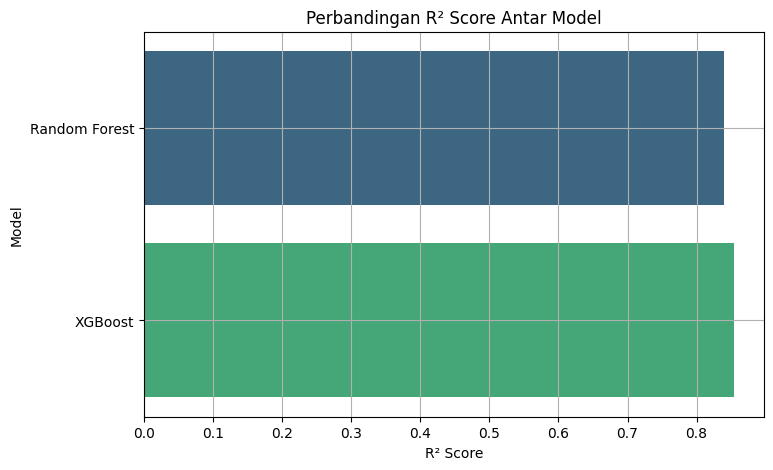

In [ ]:
# 9. Visualisasi R2 per model
plt.figure(figsize=(8, 5))
sns.barplot(x='R2', y='Model', data=results_df.sort_values(by='R2', ascending=True), palette='viridis')
plt.title('Perbandingan R² Score Antar Model')
plt.xlabel('R² Score')
plt.ylabel('Model')
plt.grid(True)
plt.show()